In [2]:
import numpy as np
from scipy.sparse import diags_array
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from scipy.sparse.linalg import spsolve
from tqdm.auto import tqdm
from scipy.sparse import identity
from scipy.sparse import eye_array

In [3]:
def get_burger_solver(alpha,kappa,k = 1e-4,n = 1000):
    h = 1/(n+1)

    L = diags_array([np.ones(n-1),-2 * np.ones(n),np.ones(n-1)],offsets = [-1,0,1])/(h**2)
    D = diags_array([-np.ones(n-1),np.ones(n-1)],offsets = [-1,1])/(2*h)

    xgrid = np.linspace(0,1,n+2)
    def heat_step(k,kappa,n):
        B = L * kappa * k
        I = eye_array(n)
        L1 = I - B/4
        R1 = I + B/4
        L2 = I - B/3
        def trbdf2_heat(u):
            #u1 = spsolve(L2,R1@u)
            u1 = spsolve(L1,R1@u)
            return spsolve(L2,(1/3) * (4 * u1 - u))
        return trbdf2_heat

    def rk2_burger(k,alpha):
        def Fval(u):
            return alpha * (D@u)*u
        def rk2_step(u):
            u1 = u + (k/2)* Fval(u)
            return u + k * Fval(u1)
        return rk2_step
    
    half_heat = heat_step(k = k/2,kappa=kappa,n=n)
    burgers = rk2_burger(k = k,alpha = alpha)

    def get_ss_step(half_op1,op2):
        def strang_split_timestep(u):
            return half_op1(op2(half_op1(u)))
        return strang_split_timestep

    burger_split_step = get_ss_step(half_heat,burgers)

    def solve_burgers(u0,final_t = 1.):
        num_timesteps = final_t//k
        u_vals = [u0]
        u = u0
        for i in tqdm(range(int(num_timesteps))):
            u = burger_split_step(u)
            u_vals+=[u]
        return np.array(u_vals),np.arange(0,final_t,k)
    return xgrid,solve_burgers

In [4]:
xgrid,solver = get_burger_solver(1.,0.001,1e-4,n = 1000)
u0 = np.sin(8*np.pi*xgrid[1:-1])*xgrid[1:-1]*np.sqrt(1-xgrid[1:-1])
u_sol,times = solver(u0,1.)

  0%|          | 0/9999 [00:00<?, ?it/s]

In [1]:
plt.imshow(u_sol[::10])
plt.grid(None)

NameError: name 'plt' is not defined

/home/alexh/miniconda3/envs/keql/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/alexh/miniconda3/envs/keql/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


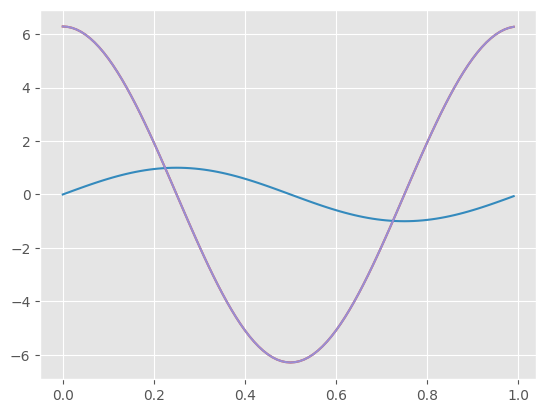

In [146]:
nx = 100
x = np.linspace(0,1,nx,endpoint=False)
y = np.sin(2*np.pi*x)

k = 2*np.pi*np.fft.fftfreq(nx,x[1] - x[0])
yhat = np.fft.fft(y)
#plt.plot(k,yhat)

plt.plot(x,np.fft.ifft((1j)*yhat*k))
plt.plot(x,np.fft.ifft(yhat))
plt.plot(x,2*np.pi*np.cos(2*np.pi*x))

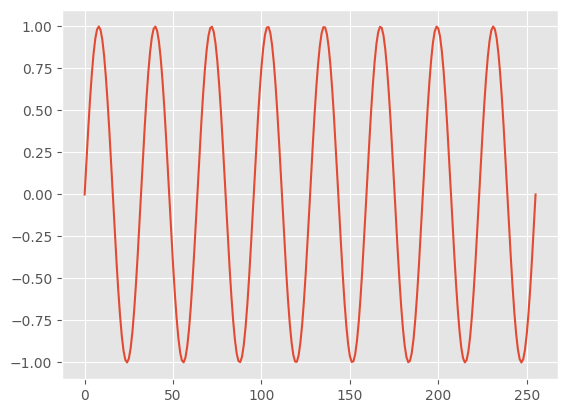

Text(0.5, 1.0, 'Kuramoto-Sivashinsky: L = 100, nu = 1')

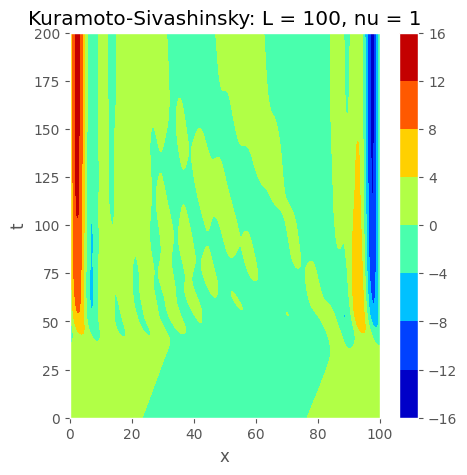

In [38]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.pyplot import cm

nu = 1
L = 100 
nx = 1024

t0 = 0 
tN = 200
dt = 0.05
nt = int((tN - t0) / 0.05)

# wave number mesh
k = np.arange(-nx/2, nx/2, 1)

t = np.linspace(start=t0, stop=tN, num=nt)
x = np.linspace(start=0, stop=L, num=nx)

# solution mesh in real space
u = np.ones((nx, nt))
# solution mesh in Fourier space
u_hat = np.ones((nx, nt), dtype=complex)

# initial condition 
u0 = np.cos((2 * np.pi * x) / L) + 0.1 * np.cos((4 * np.pi * x) / L)

# Fourier transform of initial condition
u0_hat = (1 / nx) * np.fft.fftshift(np.fft.fft(u0))

# set initial condition in real and Fourier mesh
u[:,0] = u0
u_hat[:,0] = u0_hat

# Fourier Transform of the linear operator
FL = (((2 * np.pi) / L) * k) ** 2 - nu * (((2 * np.pi) / L) * k) ** 4
# Fourier Transform of the non-linear operator
FN = - (1 / 2) * ((1j) * ((2 * np.pi) / L) * k)

# resolve EDP in Fourier space
for j in range(0,nt-1):
  uhat_current = u_hat[:,j]
  if j == 0:
    uhat_last = u_hat[:,0]
  else:
    uhat_last = u_hat[:,j-1]
  
  # compute solution in Fourier space through a finite difference method
  # Cranck-Nicholson + Adam 
  u_hat[:,j+1] = (1 / (1 - (dt / 2) * FL)) * ( (1 + (dt / 2) * FL) * uhat_current + ( ((3 / 2) * FN) * (uhat_current ** 2) - ((1 / 2) * FN) * (uhat_last ** 2) ) * dt )
  # go back in real space
  u[:,j+1] = np.real(nx * np.fft.ifft(np.fft.ifftshift(u_hat[:,j+1])))

# plot the result
fig, ax = plt.subplots(figsize=(5,5))

xx, tt = np.meshgrid(x, t)
levels = np.arange(-3, 3, 0.01)
cs = ax.contourf(xx, tt, u.T, cmap=cm.jet)
fig.colorbar(cs)

ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_title(f"Kuramoto-Sivashinsky: L = {L}, nu = {nu}")
